In [2]:
import re 
import os
import vrplib
import random
import matplotlib.pyplot as plt

# 准备工作

In [3]:

#按文件名排序加载数据
def read_all_instances(root_folder, ending='.tsp'):  
    instances = []  
    
    def extract_k_number(file_name):  
        match = re.search(r'k(\d+)', file_name)  
        if match:  
            return int(match.group(1))
        return float('inf')  

    file_names = sorted(  
        [file_name for file_name in os.listdir(root_folder) if file_name.endswith(ending)],  
        key=extract_k_number 
    )   
    for file_name in file_names:  
        instance = vrplib.read_instance(str(os.path.join(root_folder, file_name))) 
        if instance:  
            instances.append(instance)  
            print(f'Successfully read {file_name}')  
        else:
            print(f'Failed to read {file_name}')  
    
    return instances  

In [5]:
root_folder = './data/cvrp/new_data/'  
cvrp_instances = read_all_instances(root_folder, ending='.vrp')
for i in range(len(cvrp_instances)):
    cvrp_instance = cvrp_instances[i]
    vehicle_capacity = cvrp_instance['capacity']
    demands = cvrp_instance['demand']
    distance_matrix = cvrp_instance['edge_weight']
    node_coords = cvrp_instance['node_coord']
    #print(cvrp_instance['comment'])
    match = re.search(r"No of trucks: (\d+)", str(cvrp_instance['comment']))  
    if match:  
        num_vehicles = int(match.group(1))  


Successfully read A-n34-k5.vrp
Successfully read A-n32-k5.vrp
Successfully read A-n36-k5.vrp
Successfully read A-n33-k5.vrp
Successfully read A-n37-k5.vrp
Successfully read A-n38-k5.vrp
Successfully read A-n39-k5.vrp
Successfully read A-n39-k6.vrp
Successfully read A-n37-k6.vrp
Successfully read A-n33-k6.vrp
Successfully read A-n44-k6.vrp
Successfully read A-n45-k6.vrp
Successfully read A-n53-k7.vrp
Successfully read A-n46-k7.vrp
Successfully read A-n54-k7.vrp
Successfully read A-n45-k7.vrp
Successfully read A-n48-k7.vrp
Successfully read A-n62-k8.vrp
Successfully read A-n65-k9.vrp
Successfully read A-n69-k9.vrp
Successfully read A-n61-k9.vrp
Successfully read A-n64-k9.vrp
Successfully read A-n55-k9.vrp
Successfully read A-n60-k9.vrp
Successfully read A-n63-k9.vrp
Successfully read A-n63-k10.vrp
Successfully read A-n80-k10.vrp


In [4]:
# Function to visualize solution
def plot_CVRP_solution(routes, node_coords):
    plt.figure(figsize=(10, 8))
    
    # Plot nodes
    for i, (x, y) in enumerate(node_coords):
        plt.scatter(x, y, c='blue' if i == 0 else 'red')
        plt.text(x, y, f'{i}', fontsize=9, ha='right')
    
    # Plot routes
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for vehicle, route in enumerate(routes):
        route_coords = [node_coords[0]] + [node_coords[node] for node in route] + [node_coords[0]]
        x_coords, y_coords = zip(*route_coords)
        plt.plot(x_coords, y_coords, c=colors[vehicle % len(colors)], label=f'Vehicle {vehicle + 1}')
    
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Vehicle Routing Problem Solution')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to test vehicle capacity constraint
def test_capacity_constraint(routes, demands, vehicle_capacity):
    for vehicle, route in enumerate(routes):
        total_demand = sum(demands[node] for node in route)
        if total_demand > vehicle_capacity:
            print(f"Vehicle {vehicle + 1} exceeds capacity: {total_demand} > {vehicle_capacity}")
        else:
            print(f"Vehicle {vehicle + 1} is within capacity: {total_demand} <= {vehicle_capacity}")


# Function to calculate route distance
def calculate_route_distance(route, distance_matrix):
    distance = 0
    if route:
        distance += distance_matrix[0][route[0]]  # From depot to first node
        for i in range(1, len(route)):
            distance += distance_matrix[route[i-1]][route[i]]
        distance += distance_matrix[route[-1]][0]  # From last node back to depot
    return distance

# Function to calculate total distance of all routes (CVRP)
def total_distance(routes, distance_matrix):
    return sum(calculate_route_distance(route, distance_matrix) for route in routes)


# Generate initial solution using a greedy approach
def greedy_initial_solution():
    routes = [[] for _ in range(num_vehicles)]
    current_load = [0] * num_vehicles
    visited = [False] * num_nodes
    visited[0] = True  # Starting from the depot

    for vehicle in range(num_vehicles):
        current_node = 0
        while True:
            next_node = None
            min_distance = float('inf')
            for i in range(1, num_nodes):
                if not visited[i] and current_load[vehicle] + demands[i] <= vehicle_capacity:
                    if distance_matrix[current_node][i] < min_distance:
                        min_distance = distance_matrix[current_node][i]
                        next_node = i
            if next_node is None:
                break
            routes[vehicle].append(next_node)
            current_load[vehicle] += demands[next_node]
            visited[next_node] = True
            current_node = next_node
    return routes


# Large Neighborhood Search, LNS

**大邻域搜索（Large Neighborhood Search, LNS）** 优化技术。

算法的基本原理：
初始解生成：

使用贪心算法（greedy_initial_solution）构造初始解，为每辆车分配尽可能多的客户，但同时保证不超过车辆容量。
破坏-修复策略（Destroy and Repair）：

- 破坏（Destroy Phase）：通过destroy_solution函数，随机移除一些客户（例如 destruction_size 个客户）从当前解中，制造一个部分解。
- 修复（Repair Phase）：通过repair_solution函数，将被移除的客户重新插入部分解中，尽量使重新插入的成本最小化，生成一个新的解决方案。
循环优化（Iterative Optimization）：

使用一定次数（例如 1000 次迭代）的破坏-修复操作，尝试寻找更优的路径。
不断比较每次修复后的解与当前最优解，如果发现新的解更优（路线总距离更短），则更新当前解和最优解。
约束检查：

在修复阶段，repair_solution会检查车辆容量约束，保证插入的客户不会导致分配给一个车辆的总需求超过其容量。


算法特点：
- 启发式方法：大邻域搜索是一种启发式算法，目的是探索更大的解空间，跳出局部最优解。
- 灵活性：破坏和修复的过程可以通过参数（例如破坏规模）来调整，以适应不同的问题规模。
- 效率高：在实际应用中，大邻域搜索算法常常具有较好的收敛速度，并且能在合理时间内求得高质量的解。


In [5]:
def destroy_solution(routes, num_customers_to_remove):
    # Flatten routes to get a list of all customers
    all_customers = [customer for route in routes for customer in route]

    # Randomly select customers to remove
    removed_customers = random.sample(all_customers, num_customers_to_remove)

    new_routes = []
    for route in routes:
        new_route = [customer for customer in route if customer not in removed_customers]
        new_routes.append(new_route)
    
    return new_routes, removed_customers


In [6]:
def repair_solution(routes, removed_customers, distance_matrix, demands, vehicle_capacity, num_vehicles):
    for customer in removed_customers:
        best_insertion = None
        best_cost_increase = float('inf')
        best_route_idx = None
        best_insert_position = None

        for route_idx, route in enumerate(routes):
            route_demand = sum(demands[node] for node in route)

            if route_demand + demands[customer] > vehicle_capacity:
                continue # skip this route

            for i in range(len(route) + 1): # +1 you are allowed to insert the customer to the end
                new_route = route[:i] + [customer] + route[i:] # A - B -> Insert C. Cost(A-C-B) -  Cost (A-B)
                cost_increase = calculate_route_distance(new_route, distance_matrix) - calculate_route_distance(route, distance_matrix)
                if cost_increase < best_cost_increase:
                    best_cost_increase = cost_increase
                    best_insertion = new_route
                    best_route_idx = route_idx
                    best_insert_position = i
            
        if best_insertion is not None:
            routes[best_route_idx] = best_insertion
        else:
            if len(routes) < num_vehicles:
                routes.append([customer])
            else:
                routes[0].append(customer)

    return routes

In [7]:
def large_neighborhood_search_cvrp(distance_matrix, demands, num_vehicles, vehicle_capacity, num_iterations = 1000, destruction_size= 5):
    current_routes = greedy_initial_solution()
    current_cost = sum(calculate_route_distance(route, distance_matrix) for route in current_routes)
    best_routes = [route.copy() for route in current_routes]
    best_cost = current_cost

    for iteration in range(num_iterations):

        # Destroy Phase
        partial_routes, removed_customers = destroy_solution(current_routes, destruction_size)

        # Repair Phase
        repaired_routes = repair_solution(partial_routes, removed_customers, distance_matrix, demands, vehicle_capacity, num_vehicles)

        # Calculate the new cost of the repaired solution
        repaired_cost = sum(calculate_route_distance(route, distance_matrix) for route in repaired_routes)

        # Comparision
        if repaired_cost < current_cost:
            current_routes = [route.copy() for route in repaired_routes]
            current_cost = repaired_cost

            if current_cost < best_cost:
                best_routes = [route.copy() for route in current_routes]
                best_cost = current_cost

    return best_routes, best_cost

# small

Successfully read A-n32-k5.vrp
Successfully read A-n37-k5.vrp
Successfully read A-n48-k7.vrp
Successfully read P-n50-k10.vrp
===================== (Augerat et al, No of trucks: 5, Optimal value: 784) =====================
Number of Nodes: 32
Best routes found: [[30, 12, 1, 13, 2, 3], [20, 5, 25, 10, 15, 29, 27], [6, 23, 28, 4, 11, 8, 18, 9, 22, 14], [16, 21, 31, 19, 17, 7, 26], [24]]
Best total distance: 821
Vehicle 1 is within capacity: 97 <= 100
Vehicle 2 is within capacity: 91 <= 100
Vehicle 3 is within capacity: 98 <= 100
Vehicle 4 is within capacity: 100 <= 100
Vehicle 5 is within capacity: 24 <= 100


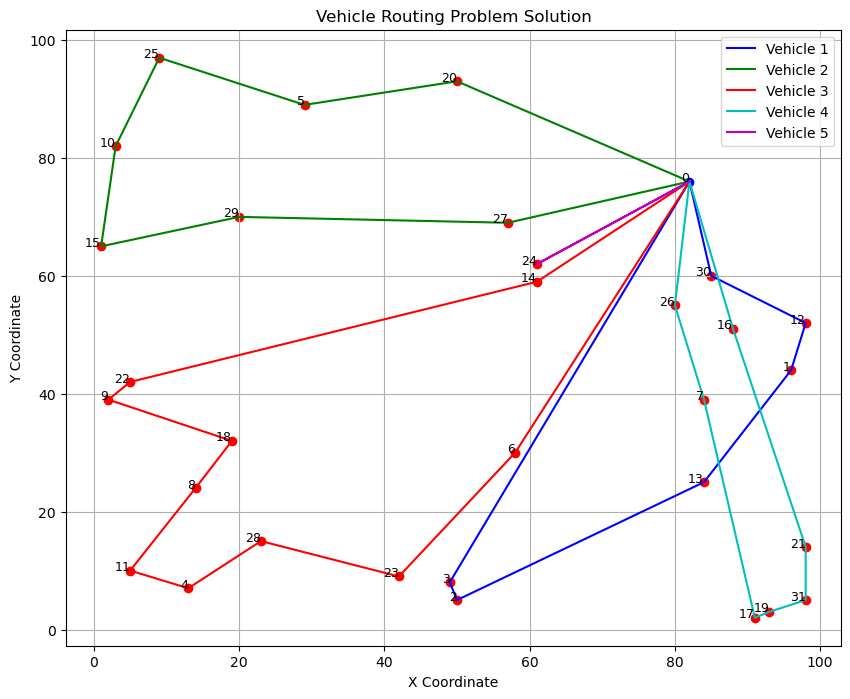

===================== (Augerat et al, No of trucks: 5, Optimal value: 669) =====================
Number of Nodes: 37
Best routes found: [[7, 4, 33, 5, 13, 22, 16], [29, 32, 28, 31, 26, 18, 35, 25, 30, 15], [12, 10, 6, 2, 19, 20, 14], [21, 1, 17, 23, 24, 9, 11, 27, 8, 3], [34, 36]]
Best total distance: 666
Vehicle 1 is within capacity: 86 <= 100
Vehicle 2 is within capacity: 98 <= 100
Vehicle 3 is within capacity: 99 <= 100
Vehicle 4 is within capacity: 97 <= 100
Vehicle 5 is within capacity: 27 <= 100


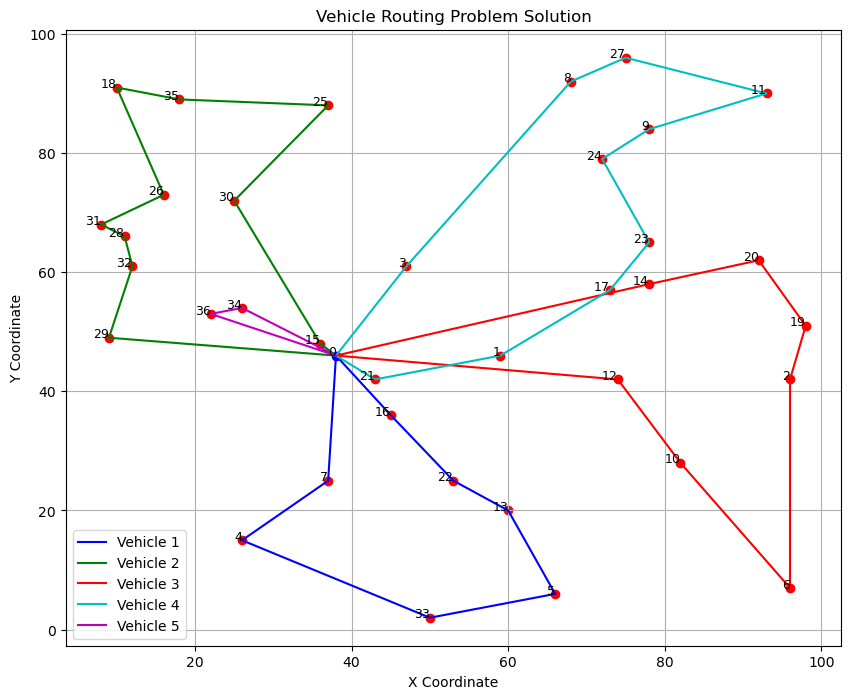

===================== (Augerat et al, No of trucks: 7, Optimal value: 1073) =====================
Number of Nodes: 48
Best routes found: [[14, 17, 47, 16], [18, 44, 23, 12], [43, 31, 5, 1, 6, 22, 35], [41, 2, 10, 33, 21, 29, 45], [40, 36, 37, 19, 25, 38, 32], [27, 15, 8, 39, 26, 20, 3, 7], [28, 30, 46, 13, 24, 4, 11, 42, 9, 34]]
Best total distance: 1071
Vehicle 1 is within capacity: 66 <= 100
Vehicle 2 is within capacity: 64 <= 100
Vehicle 3 is within capacity: 100 <= 100
Vehicle 4 is within capacity: 100 <= 100
Vehicle 5 is within capacity: 100 <= 100
Vehicle 6 is within capacity: 100 <= 100
Vehicle 7 is within capacity: 96 <= 100


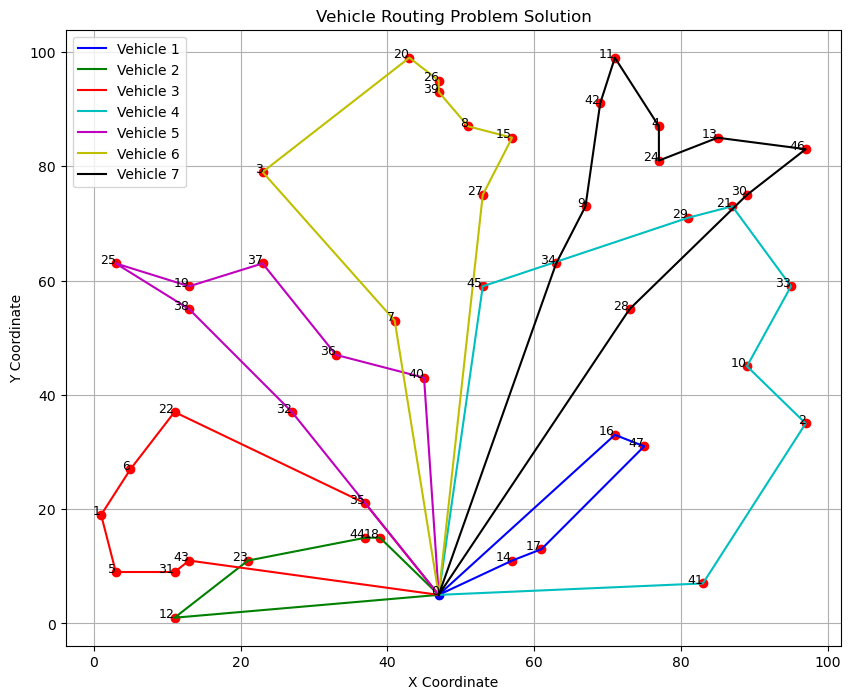

===================== (Augerat et al, No of trucks: 10, Optimal value: 696) =====================
Number of Nodes: 50
Best routes found: [[26, 11, 39, 9, 40], [4, 34, 46, 8], [2, 30, 29, 45, 27], [7, 35, 19, 14, 38], [13, 15, 20, 37, 36, 5], [6, 33, 1, 16], [3, 44, 32, 17], [12, 10, 31, 25, 18], [28, 21, 47, 48], [49, 24, 23, 43, 41, 42, 22]]
Best total distance: 726
Vehicle 1 exceeds capacity: 133 > 100
Vehicle 2 is within capacity: 92 <= 100
Vehicle 3 is within capacity: 99 <= 100
Vehicle 4 is within capacity: 95 <= 100
Vehicle 5 is within capacity: 89 <= 100
Vehicle 6 is within capacity: 83 <= 100
Vehicle 7 is within capacity: 76 <= 100
Vehicle 8 is within capacity: 94 <= 100
Vehicle 9 is within capacity: 96 <= 100
Vehicle 10 is within capacity: 94 <= 100


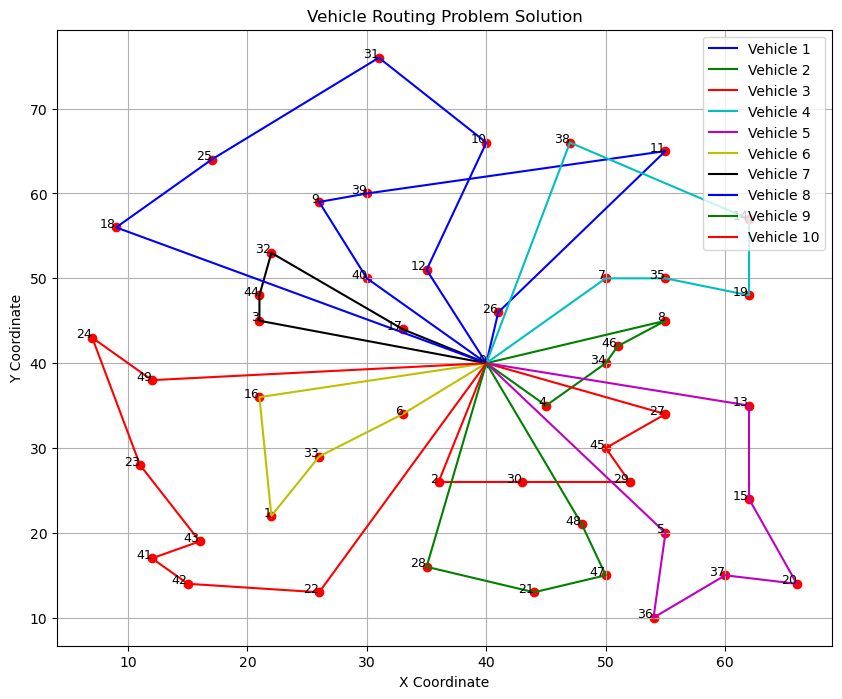

In [12]:
#root_folder = './data/cvrp/new_data/'  
#root_folder = './data/cvrp/solved'  
root_folder = './data/cvrp/small'  
#root_folder = './data/cvrp/medium'  
#root_folder = './data/cvrp/large'  
cvrp_instances = read_all_instances(root_folder, ending='.vrp')

for i in range(len(cvrp_instances)):
    cvrp_instance = cvrp_instances[i]
    vehicle_capacity = cvrp_instance['capacity']
    demands = cvrp_instance['demand']
    distance_matrix = [[int(value) for value in row] for row in cvrp_instance['edge_weight']]
    node_coords = cvrp_instance['node_coord']
    print("=====================",cvrp_instance['comment'],"=====================")
    match = re.search(r"No of trucks: (\d+)", str(cvrp_instance['comment']))  
    if match:  
        num_vehicles = int(match.group(1))  
    else:
        match_min_no_of_trucks = re.search(r"Min no of trucks: (\d+)", str(cvrp_instance['comment']))  
        if match_min_no_of_trucks:  
            num_vehicles = int(match_min_no_of_trucks.group(1))  
        else:  
            # 如果两种匹配都失败，返回 None 或处理异常  
            num_vehicles = None  

    num_nodes = len(node_coords)
    print("Number of Nodes:",num_nodes)
    best_routes, best_cost = large_neighborhood_search_cvrp(distance_matrix, demands, num_vehicles, vehicle_capacity, num_iterations=1000, destruction_size=5)
    print("Best routes found:", best_routes)
    print("Best total distance:", best_cost)
    test_capacity_constraint(best_routes, demands, vehicle_capacity)
    plot_CVRP_solution(best_routes, node_coords)

# Medium

In [13]:
#root_folder = './data/cvrp/new_data/'  
#root_folder = './data/cvrp/solved'  
#root_folder = './data/cvrp/small'  
root_folder = './data/cvrp/medium'  
#root_folder = './data/cvrp/large'  
cvrp_instances = read_all_instances(root_folder, ending='.vrp')

for i in range(len(cvrp_instances)):
    cvrp_instance = cvrp_instances[i]
    vehicle_capacity = cvrp_instance['capacity']
    demands = cvrp_instance['demand']
    distance_matrix = [[int(value) for value in row] for row in cvrp_instance['edge_weight']]
    node_coords = cvrp_instance['node_coord']
    print("=====================",cvrp_instance['comment'],"=====================")
    match = re.search(r"No of trucks: (\d+)", str(cvrp_instance['comment']))  
    if match:  
        num_vehicles = int(match.group(1))  
    else:
        match_min_no_of_trucks = re.search(r"Min no of trucks: (\d+)", str(cvrp_instance['comment']))  
        if match_min_no_of_trucks:  
            num_vehicles = int(match_min_no_of_trucks.group(1))  
        else:  
            # 如果两种匹配都失败，返回 None 或处理异常  
            num_vehicles = None  

    num_nodes = len(node_coords)
    print("Number of Nodes:",num_nodes)
    best_routes, best_cost = large_neighborhood_search_cvrp(distance_matrix, demands, num_vehicles, vehicle_capacity, num_iterations=1000, destruction_size=5)
    print("Best routes found:", best_routes)
    print("Best total distance:", best_cost)
    test_capacity_constraint(best_routes, demands, vehicle_capacity)
    #plot_CVRP_solution(best_routes, node_coords)

Successfully read A-n53-k7.vrp
Successfully read A-n63-k10.vrp
Successfully read P-n65-k10.vrp
Successfully read A-n80-k10.vrp
Successfully read E-n76-k14.vrp
===================== (Augerat et al, No of trucks: 7, Optimal value: 1010) =====================
Number of Nodes: 53
Best routes found: [[4, 28, 22, 30, 44, 46, 8, 51], [20, 6, 38, 35, 31], [33, 3, 5, 14, 34, 39], [47, 9, 17, 41, 24, 11, 52], [2, 36, 50, 43, 23, 19, 15, 32, 42, 12, 7], [25, 21, 13, 16, 48, 45], [27, 18, 40, 26, 10, 29, 49, 37, 1]]
Best total distance: 1102
Vehicle 1 is within capacity: 82 <= 100
Vehicle 2 is within capacity: 88 <= 100
Vehicle 3 is within capacity: 98 <= 100
Vehicle 4 is within capacity: 99 <= 100
Vehicle 5 is within capacity: 98 <= 100
Vehicle 6 is within capacity: 100 <= 100
Vehicle 7 is within capacity: 99 <= 100
===================== (Augerat et al, No of trucks: 10, Optimal value: 1314) =====================
Number of Nodes: 63
Best routes found: [[30, 4, 38, 43, 52], [28, 57, 32, 13, 26], [

# Large

In [14]:
#root_folder = './data/cvrp/new_data/'  
#root_folder = './data/cvrp/solved'  
#root_folder = './data/cvrp/small'  
#root_folder = './data/cvrp/medium'  
root_folder = './data/cvrp/large'  
cvrp_instances = read_all_instances(root_folder, ending='.vrp')

for i in range(len(cvrp_instances)):
    cvrp_instance = cvrp_instances[i]
    vehicle_capacity = cvrp_instance['capacity']
    demands = cvrp_instance['demand']
    distance_matrix = [[int(value) for value in row] for row in cvrp_instance['edge_weight']]
    node_coords = cvrp_instance['node_coord']
    print("=====================",cvrp_instance['comment'],"=====================")
    match = re.search(r"No of trucks: (\d+)", str(cvrp_instance['comment']))  
    if match:  
        num_vehicles = int(match.group(1))  
    else:
        match_min_no_of_trucks = re.search(r"Min no of trucks: (\d+)", str(cvrp_instance['comment']))  
        if match_min_no_of_trucks:  
            num_vehicles = int(match_min_no_of_trucks.group(1))  
        else:  
            # 如果两种匹配都失败，返回 None 或处理异常  
            num_vehicles = None  

    num_nodes = len(node_coords)
    print("Number of Nodes:",num_nodes)
    best_routes, best_cost = large_neighborhood_search_cvrp(distance_matrix, demands, num_vehicles, vehicle_capacity, num_iterations=1000, destruction_size=5)
    print("Best routes found:", best_routes)
    print("Best total distance:", best_cost)
    test_capacity_constraint(best_routes, demands, vehicle_capacity)
    #plot_CVRP_solution(best_routes, node_coords)

Successfully read X-n120-k6.vrp
Successfully read X-n115-k10.vrp
Successfully read X-n139-k10.vrp
Successfully read X-n110-k13.vrp
===================== "Generated by Uchoa, Pecin, Pessoa, Poggi, Subramanian, and Vidal (2013),, Min no of trucks: 6" =====================
Number of Nodes: 120
Best routes found: [[20, 116, 107, 61, 119, 94, 84, 55, 70, 93, 16, 38, 52, 50], [54, 96, 71, 112, 45, 3, 8, 78, 39, 42, 109, 82, 13, 98, 64, 2, 12, 21, 91, 32, 80], [73, 67, 30, 118, 23, 14, 58, 83, 44, 17, 103, 117, 26, 5, 41, 99, 113, 76, 43, 49, 10], [87, 72, 102, 111, 34, 27, 11, 56, 1, 24, 37, 22, 95, 59, 100, 77, 57, 92, 6, 40, 62], [114, 90, 35, 53, 81, 69, 68, 60, 4, 85, 89, 51, 63, 104, 105, 101, 47, 108, 66, 18, 9], [31, 25, 33, 36, 115, 48, 86, 65, 74, 110, 106, 7, 97, 46, 75, 19, 28, 15, 79, 29, 88]]
Best total distance: 14294
Vehicle 1 is within capacity: 14 <= 21
Vehicle 2 is within capacity: 21 <= 21
Vehicle 3 is within capacity: 21 <= 21
Vehicle 4 is within capacity: 21 <= 21
Vehicl

# Solved

In [13]:
#root_folder = './data/cvrp/new_data/'  
root_folder = './data/cvrp/solved'  
#root_folder = './data/cvrp/small'  
#root_folder = './data/cvrp/medium'  
#root_folder = './data/cvrp/large'  
cvrp_instances = read_all_instances(root_folder, ending='.vrp')

for i in range(len(cvrp_instances)):
    cvrp_instance = cvrp_instances[i]
    vehicle_capacity = cvrp_instance['capacity']
    demands = cvrp_instance['demand']
    distance_matrix = [[int(value) for value in row] for row in cvrp_instance['edge_weight']]
    node_coords = cvrp_instance['node_coord']
    print("=====================",cvrp_instance['comment'],"=====================")
    match = re.search(r"No of trucks: (\d+)", str(cvrp_instance['comment']))  
    if match:  
        num_vehicles = int(match.group(1))  
    else:
        match_min_no_of_trucks = re.search(r"Min no of trucks: (\d+)", str(cvrp_instance['comment']))  
        if match_min_no_of_trucks:  
            num_vehicles = int(match_min_no_of_trucks.group(1))  
        else:  
            # 如果两种匹配都失败，返回 None 或处理异常  
            num_vehicles = None  

    num_nodes = len(node_coords)
    print("Number of Nodes:",num_nodes)
    best_routes, best_cost = large_neighborhood_search_cvrp(distance_matrix, demands, num_vehicles, vehicle_capacity, num_iterations=1000, destruction_size=5)
    print("Best routes found:", best_routes)
    print("Best total distance:", best_cost)
    test_capacity_constraint(best_routes, demands, vehicle_capacity)
    #plot_CVRP_solution(best_routes, node_coords)

Successfully read A-n45-k6.vrp
Successfully read P-n60-k10.vrp
Successfully read E-n101-k14.vrp
===================== (Augerat et al, No of trucks: 6, Optimal value: 944) =====================
Number of Nodes: 45
Best routes found: [[28, 7, 32, 13, 20, 22, 15], [14, 31, 35, 1, 44, 6], [9, 16, 3, 10, 8, 41, 33, 21, 5], [43, 18, 17, 11, 40, 19, 34], [24, 37, 27, 29, 26], [23, 42, 4, 36, 39, 12, 25, 2, 38]]
Best total distance: 937
Vehicle 1 exceeds capacity: 120 > 100
Vehicle 2 is within capacity: 100 <= 100
Vehicle 3 is within capacity: 91 <= 100
Vehicle 4 is within capacity: 95 <= 100
Vehicle 5 is within capacity: 86 <= 100
Vehicle 6 is within capacity: 90 <= 100
===================== (Augerat et al, No of trucks: 10, Optimal value: 744) =====================
Number of Nodes: 60
Best routes found: [[26, 12, 17, 6, 2], [4, 34, 46, 8, 35, 7], [30, 48, 47, 5, 29, 45], [52, 13, 54, 19, 14, 53], [33, 1, 22, 42, 41, 43, 16], [44, 32, 9, 40], [58, 10, 38, 11], [28, 21, 36, 37, 57, 27], [15, 2